# NetCDF Analysis 

This notebook examines the NetCDF grids for an area surrounding Fort MacMurray, Alberta Canada from April 30th to May 4th 2016.

| **Latitude**          | **Longitude**           |
|-----------------------|-------------------------|
| 56.0°N to 57.4°N      | -112.1°W to -110.7°W    |


This grid forms a **14x14 grid** of ERA5-Land cells at a resolution of 0.1° × 0.1° (~9 km per cell).

---

## Dataset Details:
- **Format**: NetCDF  
- **Driver**: GDAL NetCDF  
- **Data Type**: Float32 (32-bit floating point)  
- **Coverage**: Hourly temperature data at 2 meters above ground level.  

In [1]:
import xarray as xr
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ipywidgets as widgets
from ipywidgets import interact
import numpy as np

### Load and combine data files.

In [2]:
# Define file paths
data_dir = "../data"  # Adjust path to your data folder
file1 = os.path.join(data_dir, "ERA5-land-fort-macmurray-April30.nc")
file2 = os.path.join(data_dir, "ERA5-land-fort-macmurray-May1-2-3.nc")

# Load the NetCDF files
ds1 = xr.open_dataset(file1)
ds2 = xr.open_dataset(file2)

# Display the contents of each dataset (optional)
#print("Dataset 1:")
#print(ds1)
#print("\nDataset 2:")
#print(ds2)

# Combine datasets along the time dimension
combined_ds = xr.concat([ds1, ds2], dim="time")

# Save the combined dataset to a new file
output_file = os.path.join(data_dir, "combined_era5_fort_mcmurray.nc")
combined_ds.to_netcdf(output_file)

print(f"Combined dataset saved to: {output_file}")

# Check the combined dataset
print("Combined Dataset:")
print(combined_ds)


Combined dataset saved to: ../data/combined_era5_fort_mcmurray.nc
Combined Dataset:
<xarray.Dataset> Size: 153kB
Dimensions:     (time: 2, valid_time: 96, latitude: 14, longitude: 14)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 768B 2016-04-30 ... 2016-05-03T23...
  * latitude    (latitude) float64 112B 57.35 57.25 57.15 ... 56.25 56.15 56.05
  * longitude   (longitude) float64 112B -112.0 -112.0 -111.9 ... -110.9 -110.8
    number      int64 8B 0
    expver      (time, valid_time) object 2kB '0001' '0001' ... '0001' '0001'
Dimensions without coordinates: time
Data variables:
    t2m         (time, valid_time, latitude, longitude) float32 151kB 290.9 ....
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-12-12T13:40 GRIB

### Create dataframe from combined dataset.

In [3]:
# Load the combined NetCDF file
file_path = "../data/combined_era5_fort_mcmurray.nc"  # Adjust the path if needed
ds = xr.open_dataset(file_path)

# Flatten the dataset: Convert to long-format DataFrame
df = ds["t2m"].to_dataframe().reset_index()

# Rename the temperature column for clarity
df.rename(columns={"t2m": "temperature"}, inplace=True)

# Write DataFrame to CSV for debugging
output_csv_path = "../data/combined_era5_fort_mcmurray_debug.csv"
df.to_csv(output_csv_path, index=False)

# Inspect the DataFrame
print(df.head())
print(f"DataFrame shape: {df.shape}")
print(f"DataFrame written to: {output_csv_path}")



   time valid_time  latitude  longitude  number expver  temperature
0     0 2016-04-30     57.35    -112.05       0   0001   290.940430
1     0 2016-04-30     57.35    -111.95       0   0001   291.649963
2     0 2016-04-30     57.35    -111.85       0   0001   291.912292
3     0 2016-04-30     57.35    -111.75       0   0001   292.269775
4     0 2016-04-30     57.35    -111.65       0   0001   292.318542
DataFrame shape: (37632, 7)
DataFrame written to: ../data/combined_era5_fort_mcmurray_debug.csv


In [4]:
# Step 1: Clean the DataFrame
# Drop rows where 'temperature' is NaN
df_clean = df.dropna(subset=["temperature"])

# Step 2: Group by latitude and longitude to calculate the temperature range
temperature_range = (
    df_clean.groupby(["latitude", "longitude"])["temperature"]
    .agg(lambda x: x.max() - x.min())  # Calculate range (max - min)
    .reset_index()
    .rename(columns={"temperature": "temp_range"})
)

# Step 3: Find the cell with the maximum temperature range (widest)
max_range_cell = temperature_range.loc[temperature_range["temp_range"].idxmax()]
latitude_max_range = max_range_cell["latitude"]
longitude_max_range = max_range_cell["longitude"]

print(f"Grid cell with the widest temperature range:")
print(f"Latitude: {latitude_max_range}, Longitude: {longitude_max_range}")
print(f"Temperature range: {max_range_cell['temp_range']} K")

# Step 4: Find the cell with the minimum temperature range (narrowest)
min_range_cell = temperature_range.loc[temperature_range["temp_range"].idxmin()]
latitude_min_range = min_range_cell["latitude"]
longitude_min_range = min_range_cell["longitude"]

print(f"\nGrid cell with the narrowest temperature range:")
print(f"Latitude: {latitude_min_range}, Longitude: {longitude_min_range}")
print(f"Temperature range: {min_range_cell['temp_range']} K")

Grid cell with the widest temperature range:
Latitude: 57.35, Longitude: -111.35000000000004
Temperature range: 26.2255859375 K

Grid cell with the narrowest temperature range:
Latitude: 56.05, Longitude: -111.55000000000003
Temperature range: 22.708984375 K


### Plot Temperature Ranges

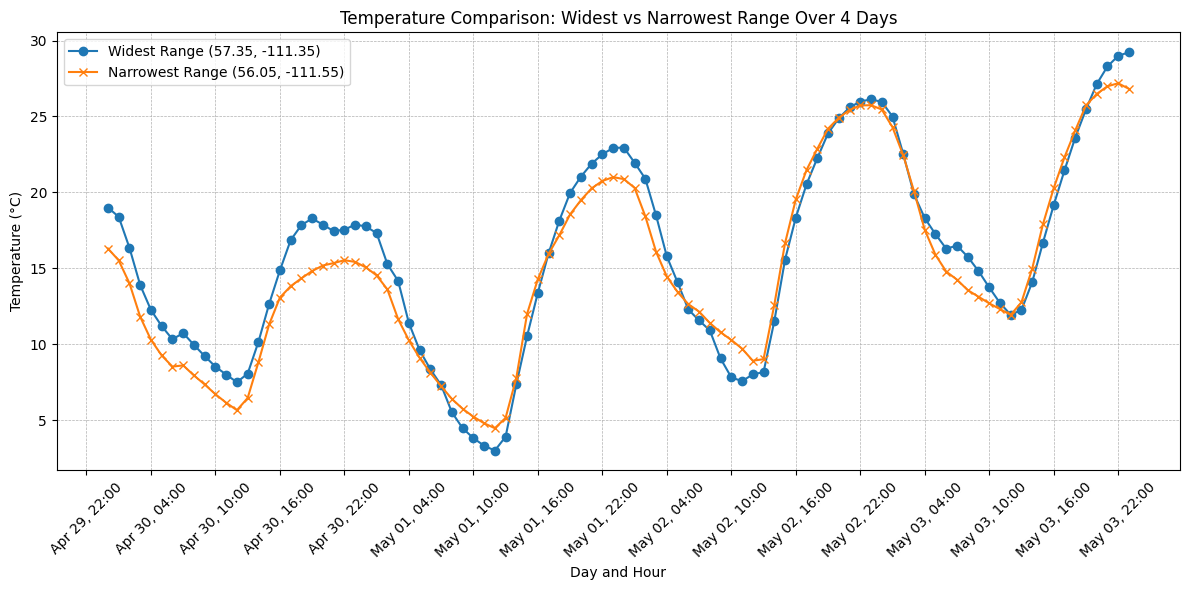

In [8]:
# Step 5: Extract temperature data for the widest temperature range cell
cell_temperature_max = df_clean[
    (df_clean["latitude"] == latitude_max_range) & (df_clean["longitude"] == longitude_max_range)
].copy()

# Extract temperature data for the narrowest temperature range cell
cell_temperature_min = df_clean[
    (df_clean["latitude"] == latitude_min_range) & (df_clean["longitude"] == longitude_min_range)
].copy()

# Convert 'valid_time' to datetime if not already
cell_temperature_max["valid_time"] = pd.to_datetime(cell_temperature_max["valid_time"])
cell_temperature_min["valid_time"] = pd.to_datetime(cell_temperature_min["valid_time"])

# Sort values by valid_time
cell_temperature_max = cell_temperature_max.sort_values(by="valid_time")
cell_temperature_min = cell_temperature_min.sort_values(by="valid_time")

# Convert temperature from Kelvin to Celsius
cell_temperature_max["temperature_c"] = cell_temperature_max["temperature"] - 273.15
cell_temperature_min["temperature_c"] = cell_temperature_min["temperature"] - 273.15

# Step 6: Plot both temperature ranges on the same plot
plt.figure(figsize=(12, 6))

# Plot widest temperature range (Celsius)
plt.plot(
    cell_temperature_max["valid_time"], 
    cell_temperature_max["temperature_c"], 
    linestyle="-", marker="o", color="tab:blue", 
    label=f"Widest Range ({latitude_max_range:.2f}, {longitude_max_range:.2f})"
)

# Plot narrowest temperature range (Celsius)
plt.plot(
    cell_temperature_min["valid_time"], 
    cell_temperature_min["temperature_c"], 
    linestyle="-", marker="x", color="tab:orange", 
    label=f"Narrowest Range ({latitude_min_range:.2f}, {longitude_min_range:.2f})"
)

# X-axis formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %H:%M'))  # Format: 'Month Day, Hour:Minute'
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))  # Major ticks every 6 hours
plt.xticks(rotation=45)

# Add titles, labels, and legend
plt.title("Temperature Comparison: Widest vs Narrowest Range Over 4 Days")
plt.xlabel("Day and Hour")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


### Display one grid.

First grid shape: (14, 14)


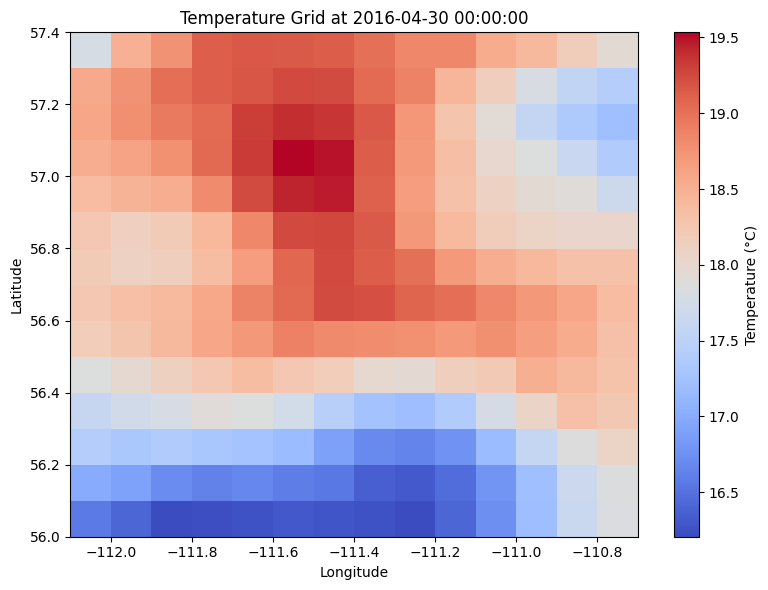

In [6]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the dataset
file_path = "../data/combined_era5_fort_mcmurray.nc"  # Adjust path as needed
ds = xr.open_dataset(file_path)

# Convert temperature from Kelvin to Celsius
ds["t2m_celsius"] = ds["t2m"] - 273.15

# Extract the first grid: time=0 and valid_time=0
first_grid = ds["t2m_celsius"].isel(time=0, valid_time=0)

# Check grid shape
print("First grid shape:", first_grid.shape)

# Plot the first grid
plt.figure(figsize=(8, 6))
plt.pcolormesh(
    ds["longitude"], ds["latitude"], first_grid, cmap="coolwarm", shading="auto"
)
plt.colorbar(label="Temperature (°C)")
time_label = pd.to_datetime(ds["valid_time"].isel(valid_time=0).values).strftime(
    "%Y-%m-%d %H:%M:%S"
)
plt.title(f"Temperature Grid at {time_label}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


### Generate animation.

In [7]:
'''
#Write out animation:

import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os

# Load the dataset
file_path = "../data/combined_era5_fort_mcmurray.nc"  # Adjust path as needed
output_folder = "../data/output_grids"  # Folder to save PNG files
os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

# Convert temperature from Kelvin to Celsius
ds = xr.open_dataset(file_path)
ds["t2m_celsius"] = ds["t2m"] - 273.15

# Function to save grids sequentially as PNG files
def save_grids_to_png():
    # Total number of valid_time steps
    num_valid_times = ds.dims["valid_time"]
    
    # Extract latitude and longitude
    longitude = ds["longitude"].values
    latitude = ds["latitude"].values
    
    # Step through each time step and save the grid
    for valid_time_index in range(num_valid_times):
        # Extract the grid for the current valid_time step
        grid = ds["t2m_celsius"].isel(time=0, valid_time=valid_time_index)
        
        # Extract the timestamp for file naming
        time_label = pd.to_datetime(ds["valid_time"].isel(valid_time=valid_time_index).values)
        time_str = time_label.strftime("%Y%m%d%H%M")
        
        # Generate file name with numeric suffix
        file_name = f"temperature_grid.{valid_time_index:04d}.png"
        file_path = os.path.join(output_folder, file_name)
        
        # Plot the grid
        plt.figure(figsize=(8, 6))
        plt.pcolormesh(longitude, latitude, grid, cmap="coolwarm", shading="auto")
        plt.colorbar(label="Temperature (°C)")
        plt.title(f"Temperature Grid at {time_label.strftime('%Y-%m-%d %H:%M:%S')}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.tight_layout()
        
        # Save the plot to disk
        plt.savefig(file_path, dpi=300)
        plt.close()  # Close the plot to free up memory
        
        print(f"Saved: {file_name}")

# Save all grids to PNG files
save_grids_to_png()
'''


'\n#Write out animation:\n\nimport xarray as xr\nimport matplotlib.pyplot as plt\nimport pandas as pd\nimport os\n\n# Load the dataset\nfile_path = "../data/combined_era5_fort_mcmurray.nc"  # Adjust path as needed\noutput_folder = "../data/output_grids"  # Folder to save PNG files\nos.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn\'t exist\n\n# Convert temperature from Kelvin to Celsius\nds = xr.open_dataset(file_path)\nds["t2m_celsius"] = ds["t2m"] - 273.15\n\n# Function to save grids sequentially as PNG files\ndef save_grids_to_png():\n    # Total number of valid_time steps\n    num_valid_times = ds.dims["valid_time"]\n    \n    # Extract latitude and longitude\n    longitude = ds["longitude"].values\n    latitude = ds["latitude"].values\n    \n    # Step through each time step and save the grid\n    for valid_time_index in range(num_valid_times):\n        # Extract the grid for the current valid_time step\n        grid = ds["t2m_celsius"].isel(time=0, valid_time